### Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

# Load train samples
with open("train.txt", "r") as f:
    reader = csv.reader(f)
    train_set = list(reader)
train_set = [element[0].split(" ") for element in train_set]
train_set = np.array(train_set).astype(np.int32)
print("Train set shape: ", train_set.shape)


with open("test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]
test_set = np.array(test_set).astype(np.int32)
print("Test set shape: ", test_set.shape)


# Load node_information.csv
node_info = pd.read_csv("node_information.csv", header=None).astype(np.int32).set_index(0)
display(node_info.head(3))


# Separate the positive and negative examples
pos_train_set = train_set[train_set[:, 2] == 1]
neg_train_set = train_set[train_set[:, 2] == 0]

print("Positive train set shape: ", pos_train_set.shape)
print("Negative train set shape: ", neg_train_set.shape)

# Use the train_set to create a graph
G = nx.Graph()

# Add nodes to the graph and features from node_info
for node in node_info.index:
    G.add_node(node, features=node_info.loc[node])

for element in pos_train_set:
    G.add_edge(element[0], element[1])


Train set shape:  (10496, 3)
Test set shape:  (3498, 2)


,1,2,3,4,5,6,7,8,9,10,...,923,924,925,926,927,928,929,930,931,932
0,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Positive train set shape:  (5248, 3)
Negative train set shape:  (5248, 3)


#### Plot the graph

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

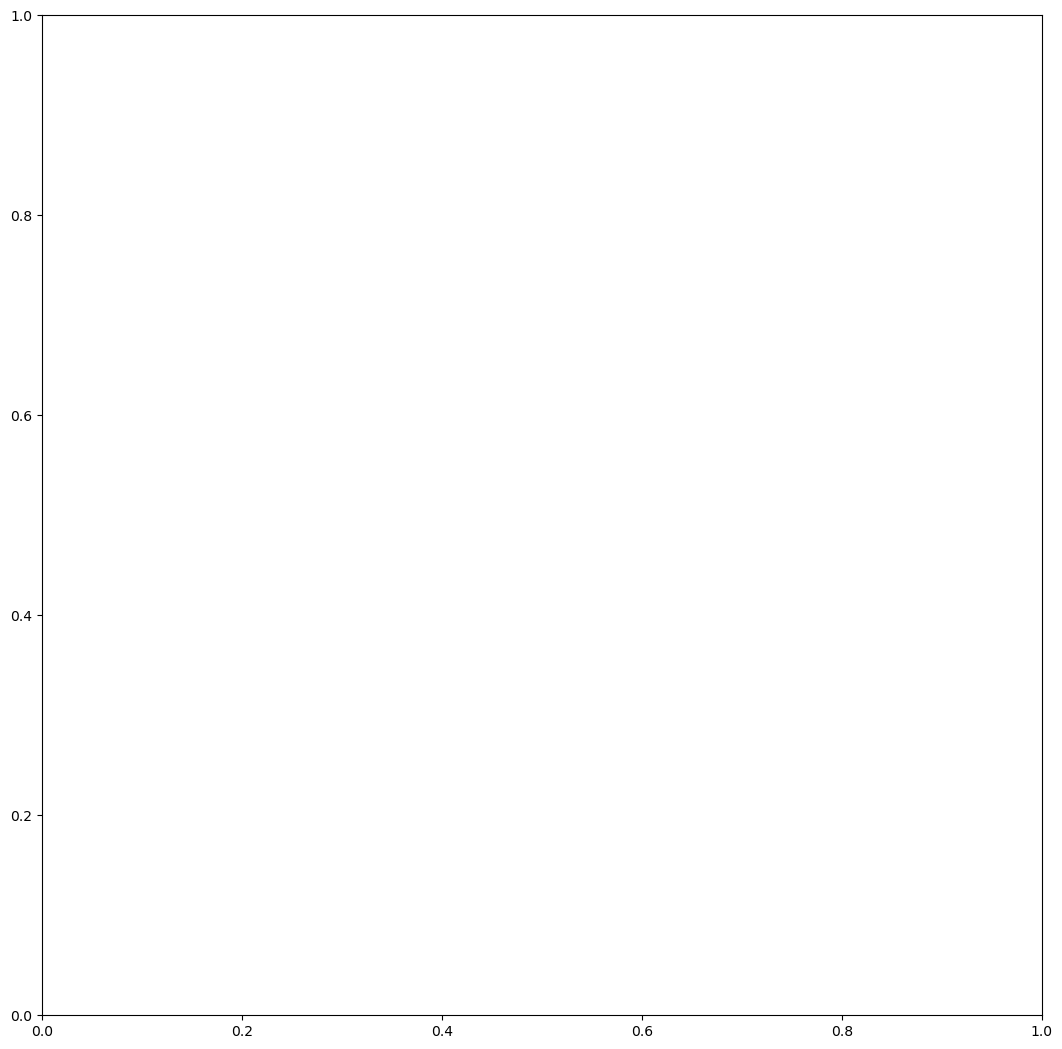

In [3]:
# Plot the graph
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True, node_size=10, font_size=8)
plt.show()

In [41]:
# Select a random node and plot its neighbors and features
node = np.random.choice(G.nodes())
print("Node: ", node)
print("Features: ", G.nodes[node]["features"])
print("Neighbors: ", list(G.neighbors(node)))


Node:  4408
Features:  1      0
2      0
3      0
4      0
5      0
      ..
928    0
929    0
930    0
931    0
932    0
Name: 4408, Length: 932, dtype: int32
Neighbors:  [6363, 5389]


### Features extraction

In [4]:
# Take a pair of nodes and build features from their individual features and the graph
def build_features(node1, node2):
    features = []
    features.append(G.nodes[node1]["features"])
    features.append(G.nodes[node2]["features"])

    features.append(G.nodes[node1]["features"] - G.nodes[node2]["features"])
    features.append(G.nodes[node1]["features"] * G.nodes[node2]["features"])

    # features.append(G.nodes[node1]["features"] / G.nodes[node2]["features"])
    # features.append(G.nodes[node2]["features"] / G.nodes[node1]["features"])

    features.append(np.array([len(list(nx.common_neighbors(G, node1, node2)))]))
    features.append(np.array(list(nx.jaccard_coefficient(G, [(node1, node2)]))[-1]))
    features.append(np.array(list(nx.resource_allocation_index(G, [(node1, node2)]))[-1]))
    # features.append(np.array(list(nx.adamic_adar_index(G, [(node1, node2)]))[-1]))
    features.append(np.array(list(nx.preferential_attachment(G, [(node1, node2)]))[-1]))
    features.append(np.array([nx.shortest_path_length(G, node1, node2)]))
    features.append(np.array([nx.clustering(G, node1)]))
    features.append(np.array([nx.clustering(G, node2)]))
    features.append(np.array([nx.clustering(G, node1) - nx.clustering(G, node2)]))
    features.append(np.array([nx.clustering(G, node2) - nx.clustering(G, node1)]))
    features.append(np.array([nx.clustering(G, node1) * nx.clustering(G, node2)]))
    
    # features.append(np.array([nx.clustering(G, node1) / nx.clustering(G, node2)]))
    # features.append(np.array([nx.clustering(G, node2) / nx.clustering(G, node1)]))
    return np.concatenate(features)


In [83]:
# Build features for the positive and negative train sets
pos_features = np.array([build_features(element[0], element[1]) for element in pos_train_set])
neg_features = np.array([build_features(element[0], element[1]) for element in neg_train_set])

# Build features for the test set
test_features = np.array([build_features(element[0], element[1]) for element in test_set])

# Build the labels for the train set
pos_labels = np.ones(pos_features.shape[0])
neg_labels = np.zeros(neg_features.shape[0])
train_labels = np.concatenate([pos_labels, neg_labels])

# Build the features for the train set
train_features = np.concatenate([pos_features, neg_features])

print("Train features shape: ", train_features.shape)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


Train features shape:  (10496, 3744)


### Random forest

In [7]:
# Call a classifier and train it
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf = RandomForestClassifier(n_estimators=50, max_depth=8, random_state=0)
clf.fit(train_features, train_labels)

# Print the accuracy on the train set
print("Train accuracy: ", clf.score(train_features, train_labels))

# Print the f1 score on the train set
print("Train f1 score: ", f1_score(train_labels, clf.predict(train_features)))

# Predict the labels for the test set
test_labels_pred = clf.predict(test_features)

pred_zip = zip(np.array(range(len(test_set))), test_labels_pred)

with open("RF_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in pred_zip:
         csv_out.writerow(row)
    pred.close()

Train accuracy:  0.8692835365853658
Train f1 score:  0.853387475956401


This classifier gave the best results yet (0.68 on Kaggle)

### Logistic regression

In [104]:
# Call a classifier and train it
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_features, train_labels)

train_preds = logreg.predict(train_features)
test_preds = logreg.predict(test_features)

# Print the accuracy on the train set
print("Train accuracy: ", logreg.score(train_features, train_labels))

# Print the f1 score on the train set
print("Train f1 score: ", f1_score(train_labels, logreg.predict(train_features)))

# Predict the labels for the test set
test_labels_pred = logreg.predict(test_features)

pred_zip = zip(np.array(range(len(test_set))), test_labels_pred)

with open("LogReg_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in pred_zip:
         csv_out.writerow(row)
    pred.close()

Train accuracy:  1.0
Train f1 score:  1.0


c:\Users\Louis\anaconda3\envs\DL_tf\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Given the Kaggle score for the prediction (0.60), this classifier overfits a lot.

### MLP Pytorch

In [103]:
# Classify with a neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Define a dataset class
class GraphDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define a neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

        self.dropout_rate = dropout_rate

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=self.dropout_rate)
        
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training, p=self.dropout_rate)

        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training, p=self.dropout_rate)

        x = self.fc4(x)
        return F.sigmoid(x)

# Define a function to train the model with tqdm
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    loss_history = []
    accuracy_history = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.float()
        target = target.unsqueeze(-1).float()

        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        loss_history.append(loss.item())

        output = output.cpu().detach().round().numpy()
        target = target.cpu().detach().numpy()
        accuracy = (output == target).sum() / len(target)
        accuracy_history.append(accuracy)

        optimizer.step()

    print(f'Epoch {epoch} - Average loss= {np.mean(loss_history):.4f}, Average accuracy= {np.mean(accuracy_history):.4f}')


# Define a function to predict the labels for the test set
def predict(model, device, test_loader):
    model.eval()
    test_labels_pred = []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            data = data.float()

            output = model(data)
            pred = output.cpu().detach().round().numpy()

            test_labels_pred.extend(pred)

    return test_labels_pred


# Define the hyperparameters
input_size = train_features.shape[1]
hidden_size = 256
output_size = 1
dropout_rate = 0.3
batch_size = 128
epochs = 15
learning_rate = 0.001
criterion = nn.BCELoss()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = Net(input_size, hidden_size, output_size, dropout_rate).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the train and test datasets
train_dataset = GraphDataset(train_features, train_labels)
test_dataset = GraphDataset(test_features, np.zeros(test_features.shape[0]))

# Define the train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)

# Predict the labels for the test set
test_labels_pred = predict(model, device, test_loader)
test_labels_pred = [e[0] for e in test_labels_pred]

pred_zip = zip(np.array(range(len(test_set))), test_labels_pred)

with open("NN_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in pred_zip:
         csv_out.writerow(row)
    pred.close()


Epoch 1 - Average loss= 0.6184, Average accuracy= 0.6490
Epoch 2 - Average loss= 0.4214, Average accuracy= 0.8160
Epoch 3 - Average loss= 0.2643, Average accuracy= 0.8917
Epoch 4 - Average loss= 0.1731, Average accuracy= 0.9353
Epoch 5 - Average loss= 0.1241, Average accuracy= 0.9510
Epoch 6 - Average loss= 0.1019, Average accuracy= 0.9632
Epoch 7 - Average loss= 0.0767, Average accuracy= 0.9741
Epoch 8 - Average loss= 0.0558, Average accuracy= 0.9803
Epoch 9 - Average loss= 0.0657, Average accuracy= 0.9814
Epoch 10 - Average loss= 0.0475, Average accuracy= 0.9843
Epoch 11 - Average loss= 0.0404, Average accuracy= 0.9867
Epoch 12 - Average loss= 0.0380, Average accuracy= 0.9877
Epoch 13 - Average loss= 0.0431, Average accuracy= 0.9903
Epoch 14 - Average loss= 0.0399, Average accuracy= 0.9909
Epoch 15 - Average loss= 0.0240, Average accuracy= 0.9925


Disappointing results on Kaggle (0.66)